In [2]:
# if you don't have some package, install it right here with 
# import Pkg; Pkg.add("Name of the Package")
using LinearAlgebra: norm, opnorm
using Plots 
using JLD2 # for saving data. One can comment it

include("problem_instances.jl")
using .Problems

## Euclidean run


| id  | function  | n  |   |   |
|---|---|---|---|---|
|probl_1| policeman_and_burglar_matrix  |  500 |   |   |
|probl_2| nemirovski1  | 500  |   |   |
|probl_3| nemirovski2   | 500  |   |   |

The first problem is randomly generated. For the paper we used seed `sd="1"`. Set `sd="false"` otherwise. For the first run of code set `m, n, N` small

In [6]:
# Choose dimensions and problem instance
m, n = 50, 50

probl = 1 # 1, 2 or 3
sd = "1"


if probl == 1
    A = Problems.policeman_and_burglar_matrix(n; seed=sd)
    filename = "save/probl_1e.jld2" 
elseif probl == 2
    A = Problems.nemirovski1(n)
    filename = "save/probl_2e.jld2" 
elseif probl == 3
    A = Problems.nemirovski2(n, 2)
    filename = "save/probl_3e.jld2"
elseif probl == 4
    A = Problems.randunif(m, n; seed=sd)
    filename = "save/probl_4e.jld2"
    
end
       

# Compute different norms of A
max_norm = maximum(abs.(A))
l2_norm = norm(A, 2)
sp_norm = opnorm(A)
print("Operator norm of A is $(round(sp_norm, digits=1)),
Frobenius norm is $(round(l2_norm, digits=1)),
max norm is $(round(max_norm, digits=1))")

x0 = ones(n)/n 
y0 = ones(m)/m

z0 = [x0; y0]
tol = 1e-8

# deterministic algorithms
step_dtr = 0.99 / sp_norm

# proposed variance reduction
K = ceil(Int64, 2*m*n/(m + n))
p = 1.0 / K
α = 1 - p
step_vr = 0.99 * sqrt(p) / l2_norm

# proposed variance reduction-looped
K = ceil(Int64, 2*m*n/(m + n))
p = 1.0 / K
α = 1 - p
step_vr = 0.99 * sqrt(p) / l2_norm

# Carmon et al. Euclidean setting
step_mult = 4.0 
alpha_ = l2_norm * sqrt((m + n)/(2 * m * n))
η = alpha_ / (step_mult * l2_norm^2);


Operator norm of A is 45.9,
Frobenius norm is 46.5,
max norm is 2.3

#### Set number of epochs `N` and run the algorithms

In [7]:
include("algorithms.jl")
projection(x) = proj_simplex1(x)

N = 1000
@time res1 = extraGrad(A, projection, z0, step_dtr, N, tol=tol)
@time res2 = stochMPCarmon(A, projection, z0, alpha_, η, N, distr=true, tol=tol)
@time res3 = stochExtraGradLooped(A, projection, z0, step_vr, α, K, N,
            bregman=false, distr=true, tol=tol)
@time res4 = stochExtraGradLoopless(A, projection, z0, step_vr, α, p, N,
            bregman=false, distr=true, tol=tol);

@save filename res1 res2 res3 res4


  0.374812 seconds (670.99 k allocations: 34.562 MiB, 5.78% gc time)
  0.766644 seconds (1.32 M allocations: 252.624 MiB, 4.56% gc time)
  0.600771 seconds (872.54 k allocations: 233.146 MiB, 3.98% gc time)
  0.539822 seconds (1.37 M allocations: 230.313 MiB, 5.05% gc time)


Timing is not important here, since we compare algorithms' performance with respect to arithmetic operations. And of course our VR-implmentation is not so good.

#### Make a quick plot

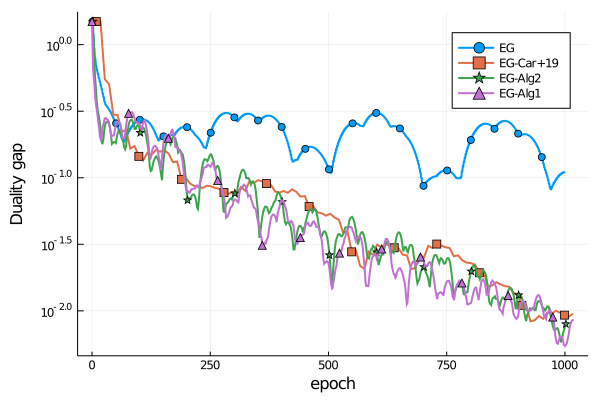

In [9]:
gr()

# some hack to put markers less frequently. From https://github.com/JuliaPlots/Plots.jl/issues/2523#issuecomment-607090470
# now their frequency is controled by parameter `step`

@recipe function f(::Type{Val{:samplemarkers}}, x, y, z; step = 500)
    n = length(y)
    sx, sy = x[1:step:n], y[1:step:n]
    # add an empty series with the correct type for legend markers
    @series begin
        seriestype := :path
        markershape --> :auto
        x := [Inf]
        y := [Inf]
    end
    # add a series for the line
    @series begin
        primary := false # no legend entry
        markershape := :none # ensure no markers
        seriestype := :path
        seriescolor := get(plotattributes, :seriescolor, :auto)
        x := x
        y := y
    end
    # return  a series for the sampled markers
    primary := false
    seriestype := :scatter
    markershape --> :auto
    x := sx
    y := sy
end
### end of hack

labels = ["EG","EG-Car+19", "EG-Alg2", "EG-Alg1"]
plot(res1[1], yaxis=:log, label=labels[1], legend=:topright, linewidth=2,marker=:auto, seriestype=:samplemarkers, step=50, xlabel = "epoch", ylabel = "Duality gap")
plot!(res2[4], res2[1], label=labels[2], linewidth=2,marker=:auto, seriestype=:samplemarkers, step=10)
plot!(res3[4], res3[1], label=labels[3], linewidth=2, marker=:auto, seriestype=:samplemarkers, step=50)
plot!(res4[4], res4[1], label=labels[4], linewidth=2, marker=:utriangle, seriestype=:samplemarkers, step=45)


For publication we used backend `PGFPlotsX`. It is slightly more complicated, so we put that code [below](#plots_publish) the Bregman case.


## Bregman run
All problems are the same.

In [25]:
# Choose dimensions and problem instance
m, n = 50, 50


probl = 4 # 1, 2 or 3
sd = "1"

if probl == 1
    A = Problems.policeman_and_burglar_matrix(n; seed=sd)
    filename = "save/probl_1b.jld2" 
elseif probl == 2
    A = Problems.nemirovski1(n)
    filename = "save/probl_2b.jld2" 
elseif probl == 3
    A = Problems.nemirovski2(n, 2)
    filename = "save/probl_3b.jld2" 
elseif probl == 4
    A = Problems.randunif(m, n; seed=sd)
    filename = "save/probl_4b.jld2"
    
end



# Compute different norms of A
max_norm = maximum(abs.(A))
l2_norm = norm(A, 2)
sp_norm = opnorm(A)
print("Operator norm of A is $(round(sp_norm, digits=1)),
Frobenius norm is $(round(l2_norm, digits=1)),
max norm is $(round(max_norm, digits=1))")

x0 = ones(n)/n 
y0 = ones(m)/m
z0 = [x0; y0]
tol = 1e-8

# deterministic algorithm
step_dtr_br = 0.99 / max_norm

# proposed variance reduction
K = ceil(Int64, 2*m*n/(m + n))
p = 1.0 / K
α = 1 - p
step_vr_br = 0.99 * sqrt(p) / max_norm

# proposed variance reduction-looped
K = ceil(Int64, 2*m*n/(m + n))
p = 1.0 / K
α = 1 - p
step_vr_br = 0.99 * sqrt(p) / max_norm

# Carmon et al. Bregman setting
step_mult = 10.0 
alpha_br = max_norm * sqrt((m + n)/(2 * m * n))
η_br = alpha_br / (step_mult * max_norm^2);



Operator norm of A is 25.3,
Frobenius norm is 29.0,
max norm is 1.0

#### Set number of epochs `N` and run the algorithms

In [34]:
include("algorithms.jl")

N = 1000

@time res1 = extraGrad_bregman(A, z0, step_dtr_br, N, tol=tol) 
@time res2 = stochMPCarmon(A, projection, z0, alpha_br, η_br, N, distr=true, bregman=true, tol=tol);
@time res3 = MirProxVR(A, z0, step_vr_br, α, K, N, tol=tol);


@save filename res1 res2 res3

  0.223221 seconds (217.29 k allocations: 11.132 MiB)
  1.081470 seconds (1.78 M allocations: 490.585 MiB, 7.70% gc time)
StochMirProx-VR algorithm achieved 1.0e-8 accuracy
  0.437424 seconds (622.27 k allocations: 169.861 MiB, 7.91% gc time)


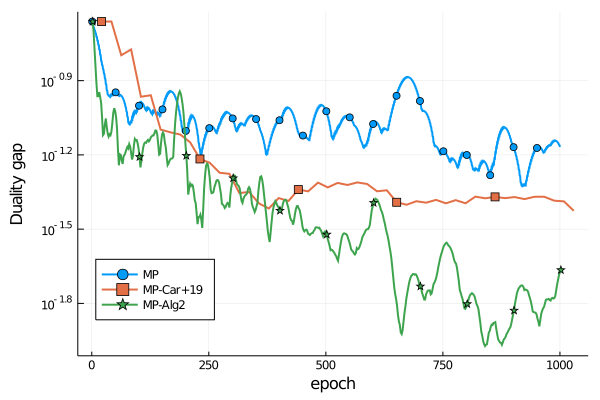

In [30]:
gr()
labels = ["MP","MP-Car+19", "MP-Alg2"]
plot(res1[1], yaxis=:log, label=labels[1], legend=:bottomleft, linewidth=2,marker=:auto, seriestype=:samplemarkers, step=50, xlabel = "epoch", ylabel = "Duality gap")
plot!(res2[4], res2[1], label=labels[2], linewidth=2,marker=:auto, seriestype=:samplemarkers, step=10)
plot!(res3[4], res3[1], label=labels[3], linewidth=2, marker=:auto, seriestype=:samplemarkers, step=50)


<a id='plots_publish'></a>

### Plots for publishing

First choose the problem and load data

In [17]:
using PGFPlotsX
using LaTeXStrings
#import Pkg; Pkg.add("LaTeXStrings")

# load data 
probl = 1 # 1, 2 or 3
sd = "1"

if probl == 1
    A = Problems.policeman_and_burglar_matrix(n; seed=sd)
    filename = "save/probl_1e.jld2" 
elseif probl == 2
    A = Problems.nemirovski1(n)
    filename = "save/probl_2e.jld2" 
elseif probl == 3
    A = Problems.nemirovski2(n, 2)
    filename = "save/probl_3e.jld2" 
elseif probl == 4
    A = Problems.randunif(m, n; seed=sd)
    filename = "save/probl_4e.jld2"
    
end

@load filename res1 res2 res3 res4

4-element Array{Symbol,1}:
 :res1
 :res2
 :res3
 :res4

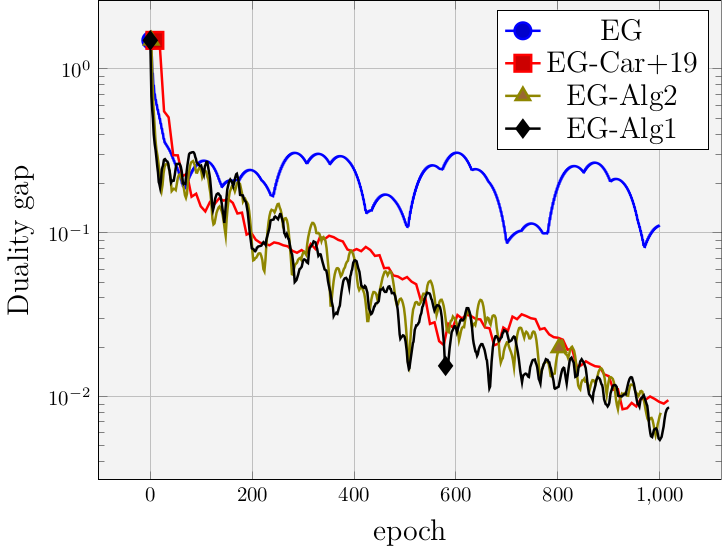

In [18]:
y1, y2, y3, y4 = res1[1], res2[1], res3[1], res4[1]
x1, x2, x3, x4 = Array(1:length(y1)), res2[4], res3[4], res4[4]


fig = @pgf Axis(
    {
        xmajorgrids, # show grids along x axis
        ymajorgrids, 
        xlabel = L"\Large{\mbox{epoch}}",  
        ylabel = L"\Large{\mbox{Duality gap}}",
        #xmode  = "log",
        ymode  = "log",
        "mark size=4pt",
        width = raw"1\textwidth",
        height = raw"0.8\textwidth",
        
        "axis background/.style" = { fill = "gray!10" }, 
   
    },
    PlotInc(
        {
            #"no marks",
            "mark repeat=1000",
            style = "{very thick}",
        },
        Coordinates(x1, y1)
    ), 
   LegendEntry(L"\Large{\mbox{EG}}"),
   
    PlotInc(
        {
            #"no marks",
            "mark repeat=200",
            style = "{very thick}",
        },
        Coordinates(x2, y2)
    ),
  LegendEntry(L"\Large{\mbox{EG-Car+19}}"),
    
       
    PlotInc(
        {
            #"no marks",
            "mark repeat=400",
            mark="triangle*",
            style = "{very thick}",
            color = "olive" 
            ### other possible colors are red, green, blue, cyan, magenta, yellow, black, gray, darkgray, lightgray, brown, lime, olive, orange, pink, purple, teal, violet and white
        },
        Coordinates(x3, y3)
    ),
  LegendEntry(L"\Large{\mbox{EG-Alg2}}"),
    
        PlotInc(
        {
            #"no marks",
            "mark repeat=300",
            #mark="x",
            mark="diamond*",
            style = "{very thick}",
        },
        Coordinates(x4, y4)
    ),
  LegendEntry(L"\Large{\mbox{EG-Alg1}}")

)


#### Save all plots in different formats

In [ ]:
base_name = chop(filename, tail=4)
pgfsave(string(base_name, "tex"), fig)
pgfsave(string(base_name, "tikz"), fig)
pgfsave(string(base_name, "pdf"), fig)

### Bregman
Load data

In [35]:

# load data 
probl = 1 # 1, 2 or 3
sd = "1"

if probl == 1
    A = Problems.policeman_and_burglar_matrix(n; seed=sd)
    filename = "save/probl_1b.jld2" 
elseif probl == 2
    A = Problems.nemirovski1(n)
    filename = "save/probl_2b.jld2" 
elseif probl == 3
    A = Problems.nemirovski2(n, 2)
    filename = "save/probl_3b.jld2" 
elseif probl == 4
    A = Problems.randunif(m, n; seed=sd)
    filename = "save/probl_4b.jld2"
    
end

@load filename res1 res2 res3 

3-element Array{Symbol,1}:
 :res1
 :res2
 :res3

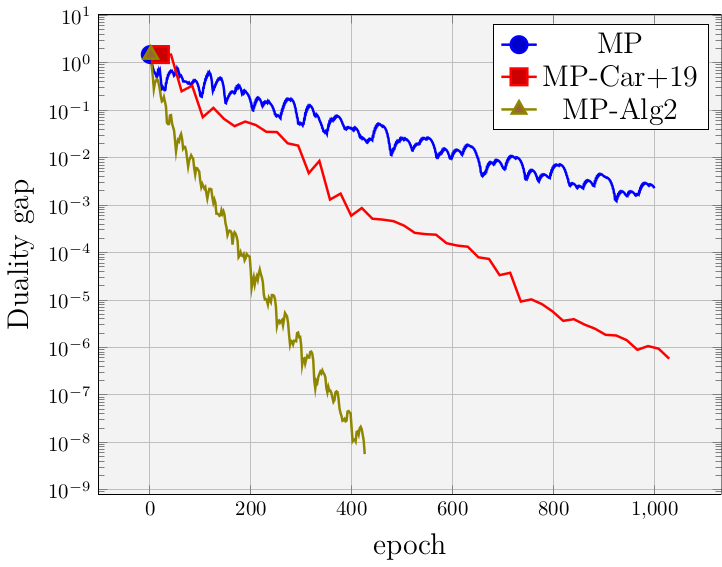

In [36]:

y1, y2, y3 = res1[1], res2[1], res3[1]
x1, x2, x3 = Array(1:length(y1)), res2[4], res3[4]


fig = @pgf Axis(
    {
        xmajorgrids, # show grids along x axis
        ymajorgrids, 
        xlabel = L"\Large{\mbox{epoch}}",  
        ylabel = L"\Large{\mbox{Duality gap}}",
        #xmode  = "log",
        ymode  = "log",
        "mark size=4pt",
        width = raw"1\textwidth",
        height = raw"0.8\textwidth",
        
        "axis background/.style" = { fill = "gray!10" }, 
   
    },
    PlotInc(
        {
            #"no marks",
            "mark repeat=2000",
            style = "{very thick}",
        },
        Coordinates(x1, y1)
    ), 
   LegendEntry(L"\Large{\mbox{MP}}"),
   
    PlotInc(
        {
            #"no marks",
            "mark repeat=50",
            style = "{very thick}",
        },
        Coordinates(x2, y2)
    ),
  LegendEntry(L"\Large{\mbox{MP-Car+19}}"),
    
       
    PlotInc(
        {
            #"no marks",
            "mark repeat=500",
            mark="triangle*",
            style = "{very thick}",
            color = "olive" 
            ### other possible colors are red, green, blue, cyan, magenta, yellow, black, gray, darkgray, lightgray, brown, lime, olive, orange, pink, purple, teal, violet and white
        },
        Coordinates(x3, y3)
    ),
  LegendEntry(L"\Large{\mbox{MP-Alg2}}"),

)


In [87]:
base_name = chop(filename, tail=4)
pgfsave(string(base_name, "tex"), fig)
pgfsave(string(base_name, "tikz"), fig)
pgfsave(string(base_name, "pdf"), fig)